In [8]:
from collections import defaultdict
from datetime import datetime
import os
import typing as tp

import cv2
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm.auto import tqdm

# Make the plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

# Amogus analysis on Reddit's /r/Place

## Introduction

The /r/Place event on Reddit has briefly made it the talk of the entire internet, attracting people from all around the web and birthing all sorts of new fads and in-jokes.

One of these is the humble amogus:

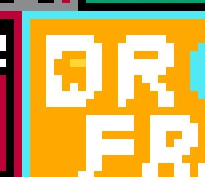

_An amogus hiding itself in the logo of the [Dropped Frames](https://droppedfram.es/) podcast._

A reference to the hit 2018 video game [Among Us](https://en.wikipedia.org/wiki/Among_Us), these are simple renditions of the game's crewmate characters on the canvas. Due to their simplicity and non-obtrusive nature, the players otherwise dissuaded from participating in a bigger community project had a freedom to spread them around the map by themselves, or with a small group of friends.

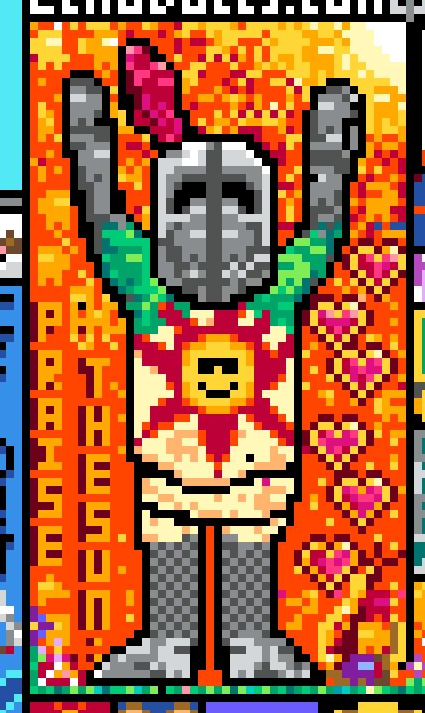

_Some are trickier to spot than others. How many can you count in this [Dark Souls](https://en.wikipedia.org/wiki/Dark_Souls) banner?_

In this notebook, we will study the phenomenon and make some conclusions on the nature of this fad.

## Visual analysis

Analysis of the supporting discussion alone won't make for a comprehensive look at the phenomenon.

To look at the picture data itself, we will use the [Looking Back at r/Place](https://place.thatguyalex.com/) dataset by /u/prosto_sanja.

Here is an example of what we will be working with - the bottom-left corner of the canvas.

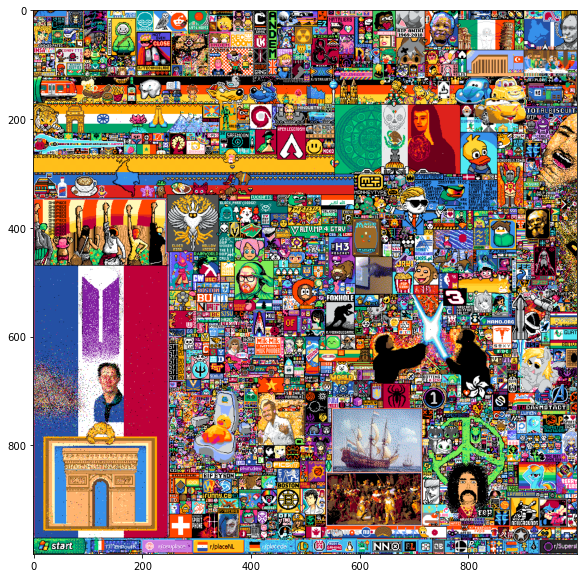

In [9]:
plt.imshow(
    cv2.cvtColor(
        cv2.imread("kaggle/input/reddit-rplace-2022-history/images_quadro/2/2-1649111699.png"),
        cv2.COLOR_BGR2RGB
    )
)
None

### How would one detect an amogus in the picture?

The following approach will be used.

First, the image will be split into 32 channels, each corresponding to a possible colour.

In [18]:
def load_image(image_type: str, timestamp: int):
    
    if image_type == "single":
        image = cv2.imread(f"kaggle/input/reddit-rplace-2022-history/images_single/0-{timestamp}.png")
    if image_type == "double":
        image_1 = cv2.imread(f"kaggle/input/reddit-rplace-2022-history/images_double/0/0-{timestamp}.png")
        image_2 = cv2.imread(f"kaggle/input/reddit-rplace-2022-history/images_double/1/1-{timestamp}.png")
        image = np.concatenate((image_1, image_2), axis=1)
    if image_type == "quadro":
        image_1 = cv2.imread(f"kaggle/input/reddit-rplace-2022-history/images_quadro/0/0-{timestamp}.png")
        image_2 = cv2.imread(f"kaggle/input/reddit-rplace-2022-history/images_quadro/1/1-{timestamp}.png")
        image_12 = np.concatenate((image_1, image_2), axis=1)
        image_3 = cv2.imread(f"kaggle/input/reddit-rplace-2022-history/images_quadro/2/2-{timestamp}.png")
        image_4 = cv2.imread(f"kaggle/input/reddit-rplace-2022-history/images_quadro/3/3-{timestamp}.png")
        image_34 = np.concatenate((image_3, image_4), axis=1)
        image = np.concatenate((image_12, image_34))
    return cv2.cvtColor(
        image,
        cv2.COLOR_BGR2RGB
    )

def autoload_image(timestamp: int):
    if f"0-{timestamp}.png" in os.listdir("kaggle/input/reddit-rplace-2022-history/images_quadro/0"):
        return load_image("quadro", timestamp)
    if f"0-{timestamp}.png" in os.listdir("kaggle/input/reddit-rplace-2022-history/images_double/0"):
        return load_image("double", timestamp)
    if f"0-{timestamp}.png" in os.listdir("kaggle/input/reddit-rplace-2022-history/images_single"):
        return load_image("single", timestamp)
    raise ValueError(f"No image found for timestamp {timestamp}")

def list_images():
    return sorted([int(i.split("-")[1].split(".")[0]) for i in
        os.listdir("kaggle/input/reddit-rplace-2022-history/images_quadro/0") +
        os.listdir("kaggle/input/reddit-rplace-2022-history/images_double/0") +
        os.listdir("kaggle/input/reddit-rplace-2022-history/images_single")
    ])

def collect_colours(image: np.array):
    colours = set()
    for x_beam in image:
        for pixel in x_beam:
            colours.add(tuple(pixel))
    return colours

COLOURS = list(collect_colours(load_image("quadro", 1649019007)))
assert len(COLOURS) == 32

def filter_image(image: np.array, colour: tp.Tuple[int, int, int]):
    colour_array = np.array(colour)[np.newaxis, np.newaxis, :]
    return 1 - np.clip(np.sum(np.abs(image - colour_array), axis=2), a_min=0, a_max=1)


def show_filtered(image: np.array, colour: tp.Tuple[int, int, int], ax=None, boundary = ((0, 2000), (0, 2000))):
    filtered = filter_image(image, colour)[..., np.newaxis]
    if ax:
        ax.imshow((image * filtered)[boundary[1][0]:boundary[1][1], boundary[0][0]:boundary[0][1]])
    else:
        plt.imshow((image * filtered)[boundary[1][0]:boundary[1][1], boundary[0][0]:boundary[0][1]])

def index_image(image: np.array):
    return np.stack([filter_image(image, i) for i in COLOURS], axis=2)

indexed_image = index_image(autoload_image(1649019007))

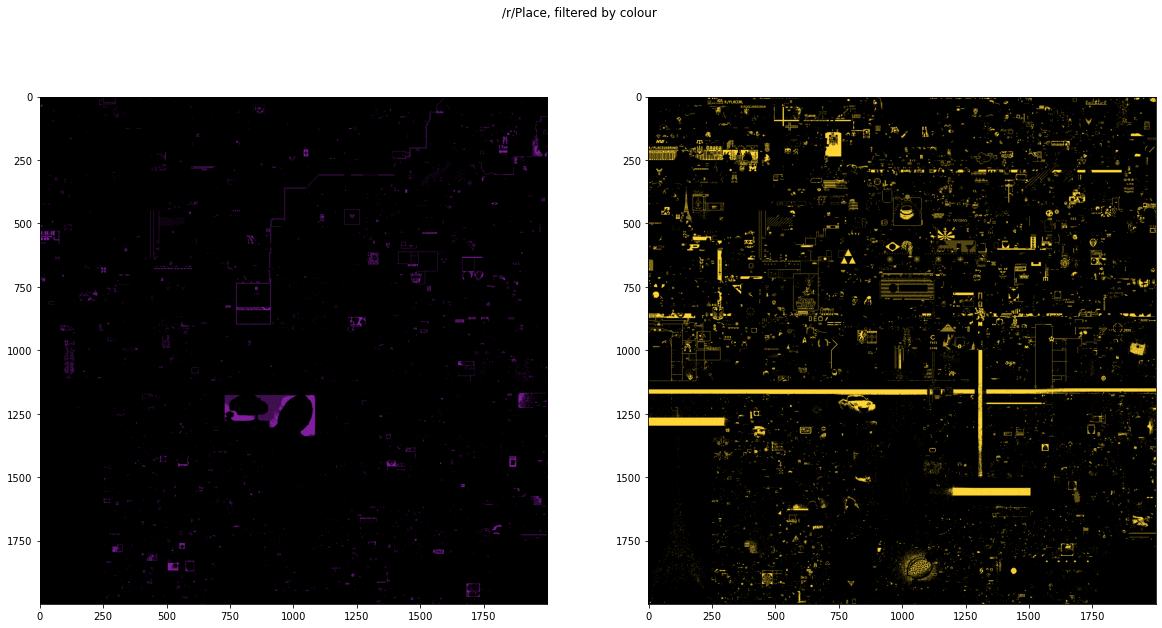

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("/r/Place, filtered by colour")

show_filtered(autoload_image(1649019007), (129, 30, 159), ax1)
show_filtered(autoload_image(1649019007), (255, 214, 53), ax2)

_Two of such channels._

In [11]:
plt.suptitle("/r/Place, filtered by colour")
show_filtered(autoload_image(1649016793), (255, 168, 0), boundary=((990, 1090), (1800, 1900)))

_A notable amogus hotspot._

### Matching the amogus patterns with computer vision

In [12]:
INITIAL_TEMPLATES = [
"""
 ###
##  
####
 # #
""",
"""
 ###
##  
####
####
 # #
""",
"""
 ###
##  
####
 ###
 # #
"""
]
def parse_template(template):
    split_template = template.split("\n")[1:-1]
    template_arr = np.zeros((len(split_template), len(split_template[0])))
    for y, line in enumerate(split_template):
        for x, char in enumerate(line):
            template_arr[y][x] = 255 * (char == "#")
    return template_arr.astype("uint8")

def augment_template(template: np.array):
    """Turn one template into many by rotating it"""
    return [
        template,
        template[::-1, :],
        template[:, ::-1],
        template[::-1, ::-1],
        template.T,
        template.T[::-1, :],
        template.T[:, ::-1],
        template.T[::-1, ::-1],
    ]

def get_templates():
    return [aug_template for template in INITIAL_TEMPLATES for aug_template in augment_template(parse_template(template))]

def match_template(layer: np.array, template: np.array):
    match = 1 - cv2.matchTemplate((layer * 255).astype("uint8"),template,cv2.TM_SQDIFF).clip(0, 1)
    total_pad = [layer.shape[i] - match.shape[i] for i in range(2)]
    match = np.pad(match, [(total_pad[i] // 2, (total_pad[i] + 1) // 2) for i in range(2)])
    return match

def match_all_templates(layer: np.array):
    templates = get_templates()
    result = match_template(layer, templates[0])
    for template in templates[1:]:
        result = np.maximum(result, match_template(layer, template))
    return result
    
def detect_amogi(image: np.array):
    result = match_all_templates(image[..., 0])
    for layer_no in range(1, image.shape[-1]):
        result = np.maximum(result, match_all_templates(image[..., layer_no]))
    return result


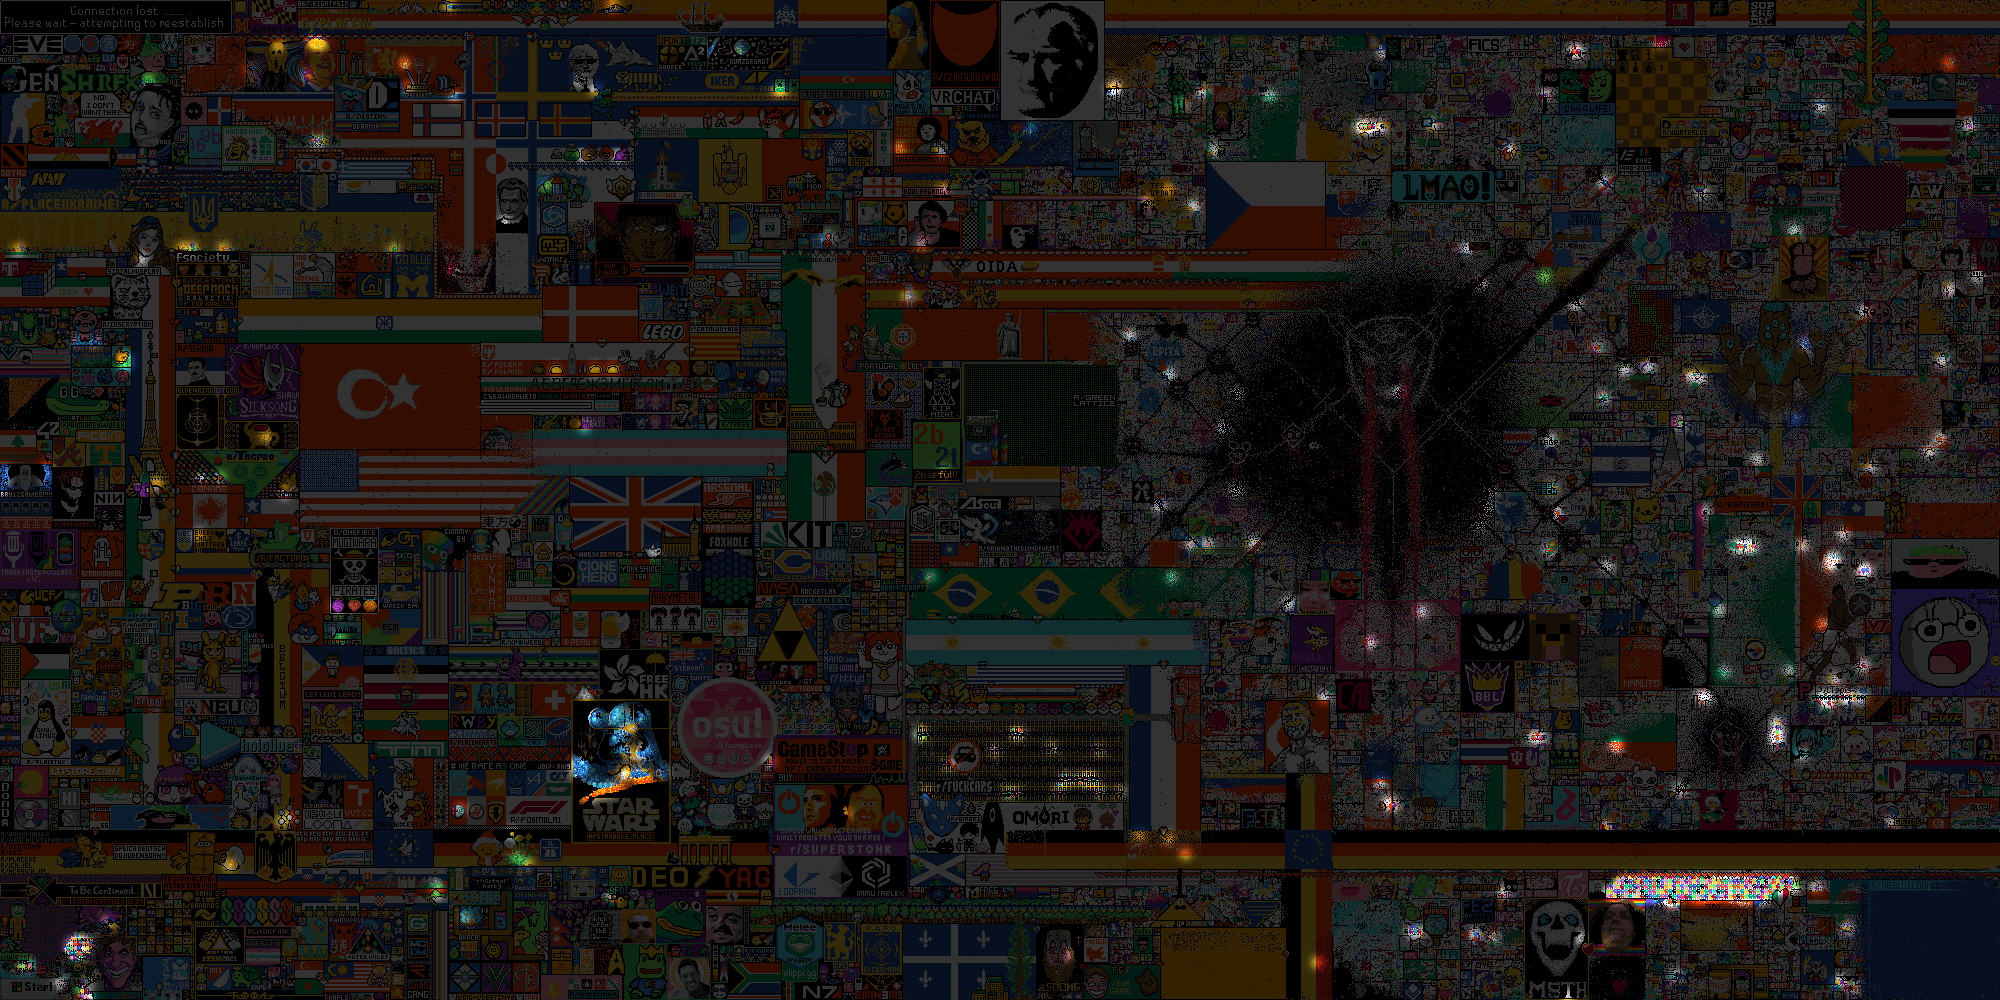

In [15]:
#from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import gaussian_filter


def interactive_amogus_map(timestamp: int):
    image = autoload_image(timestamp)
    indexed_image = index_image(image)
    amogi = detect_amogi(indexed_image)
    spotlight = gaussian_filter(amogi, sigma=5)
    spotlight /= 0.2 * np.max(spotlight)
    spotlight = spotlight.clip(0, 1)
    spotlight = 0.2 + 0.8 * spotlight
    datestring = datetime.fromtimestamp(timestamp).strftime("%A, %B %d %Y %I:%M:%S %p UTC")
    fig = px.imshow(image.astype("float32") * spotlight[..., np.newaxis] / 255, title=f"Interactive amogus map for {datestring}")
    fig.show()

interactive_amogus_map(1648924835)

_An interactive Amogus finder map. Run this notebook with your own values to see other timestamps._

In [19]:
def count_amogi_at_timestamp(timestamp: int):
    image = autoload_image(timestamp)
    indexed_image = index_image(image)
    amogi = (detect_amogi(indexed_image) >= 0.5).astype("uint8") * 255
    n_amogi, _, _, _ = cv2.connectedComponentsWithStats(amogi)
    return n_amogi

### Amogus by time plot

To save on computing time, only a fraction of source images will be used. The expected granularity will be one image per 30 minutes.

In [23]:
images_to_process = list_images()[::1000]
amogi_by_time = {datetime.fromtimestamp(timestamp): count_amogi_at_timestamp(timestamp) for timestamp in tqdm(images_to_process)}

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
%matplotlib inline
pd.Series(amogi_by_time).plot()

<AxesSubplot:>

_And that is it, a comprehensive life cycle of a short-lived internet fad._

## What's next?

For an interested reader, there are multiple avenues for deeper investigation.

 - One could raise the granularity and analyze the minute-long edges in the graph. Are there any micro-trends? Amogus raids, mass purges? Perhaps some correlation can be established.

 - One could also look for mentions of "amogus" outside of /r/Place. What communities were the most involved in the April Fools' day event? Did the discussion make any subreddit shift its preferred spelling?

 - One could look at the map over time. Are there any amogus-hostile locations? A heatmap of Amogus creation and destruction would be interesting to look at.


#### Or, if you're really feeling like social media analysis, you could head over to [SocialGrep](https://socialgrep.com?utm_source=kaggle&utm_medium=link&utm_campaign=placeamogusanalysis). Because if you want Reddit data, we have the best around.